# Introduction to the microtubule model
Author: Bettina Vignolo

This notebook was created to give a quick introduction into the Agents.jl package and how it is used in the microtubule project to facilitate its understanding.
The whole package documentation and some nice tutorials can be found here: https://juliadynamics.github.io/Agents.jl/stable/tutorial/

In order for everything to work properly you must firstly load some packages. Moreover, to be able to work with the same functions in different notebooks, you can save the functions in separate files and include them in your notebook as well at the beginning. The meaning of all of them will become clear once you go through the code and understand it.

In [1]:
# load Packages:
using Agents                #Main Package for ABM
using Statistics            #incl. mean() and std() functions
using StatsBase             #incl. more statistics-related functions
using DataFrames            #to work with dataframes
using DataFramesMeta        #additional functions for working with dataframes e.g. @transform
using Distributions         #incl. Binomial() function
using DrWatson: @dict       #to easily create dictionary out of model properties
using Serialization         #to save your data
using InteractiveDynamics   #for interactive plotting
using GLMakie               #for general plotting
import ColorSchemes as co   #for nice colorschemes in plotting

# load Functions:
include("01_Agent.jl")
include("02_Initialization.jl")
include("03_AgentStep.jl")
include("04_ModelStep.jl")
include("05_Analysis.jl")

mean_velocity_cat (generic function with 1 method)

## 1. The Space and the Agent
The type of space must be chosen (e.g. graph, a grid, etc..). In our case a GridSpace will be used (space that is discretized into boxes).

Next, the agent type that will populate the ABM must be defined. This is done as a standard Julia mutable struct that is a subtype of AbstractAgent. The type must contain two mandatory fields ```id, pos```, with the position field being appropriate for the chosen space. The remaining fields of the agent type are up to user's choice.


In [8]:
#example
mutable struct ExampleAgent <: AbstractAgent
    id::Int
    pos::Int
    property3::Float64
    property4::Bool
end

In the microtubule model our Agents are defined using the ```@agent``` makro which works similarly to the standard definition but creates a struct that automatically includes the mandatory fields required to operate in a particular space (in this case id and position). Only the additional properties and the AgentSupertype (in this case ```GridAgent{2}``` because we have a 2D Gridspace) need to be mentioned:

In [9]:
@agent tubulin GridAgent{2} begin
    polym::Int64                    # this property shows if this tubulin is part of a MT (polym > 0) and which one (each MT has another polym value)
    GDP::Bool                       # this property shows if this tubulin is hydrolized (GDP bound) or not
end

## 2. The intitialization
The created agent type, the chosen space, and optional additional model level properties (typically in the form of a dictionary) are given to our universal structure ```AgentBasedModel```. This instance defines the model within an Agents.jl simulation.

By creating an initialization function you can define the space, the model and how it should be populated with your agents. 


In [10]:
function initialize(;Nstarts::Int64, numagents::Int64, periodic::Bool, griddims::Tuple{Int64,Int64}, p_hyd::Float64,  p_polym::Float64,
    p_depolym_GTP::Float64, p_depolym_GDP::Float64, p_GTP_exchange::Float64)

    P_hyd = Binomial(1,p_hyd)                       # Prob to hydrolize from GTP to GDP:  GTPase rate
    P_polym = Binomial(1,p_polym)                   # Prob to Polymerize/bind to the microtuble 
    P_depolym_GTP = Binomial(1,p_depolym_GTP)       # Prob to depolimerize if not hydrolized (GTP - tubulin) = lower
    P_depolym_GDP = Binomial(1,p_depolym_GDP)       # Prob to depolimerize if hydrolized (GDP - tubulin) = higher
    P_GTP_exchange = Binomial(1,p_GTP_exchange)     # Prob to exchange GDP to GTP
    
    properties = @dict griddims numagents Nstarts p_depolym_GTP p_depolym_GDP p_polym p_hyd p_GTP_exchange P_hyd P_polym P_depolym_GTP P_depolym_GDP P_GTP_exchange

    properties[:tick] = 0

    space = GridSpace(griddims, periodic = periodic )   # define Gridspace with dimensions and if periodic = true or false

    model = ABM(tubulin, space;             # create model using Agents.ABM function
    scheduler = Schedulers.randomly,        # activates all agents once per step in a random order
    properties = properties )               # all parameters are given to the model as properties, so they can be consequently be accessed and used in later steps
    
    for i in 1:Nstarts                      # populating Grid Space with Startingpoints
    agent =  tubulin(i,(1,1),i,true)        # first agent with id = 1, positioned at (1,1), microtubulus id = 1, hydrolized status = true and so on
    add_agent_single!(agent, model)         # add this agent at random location
    end  

    for i in Nstarts+1:numagents            # populating Grid Space with rest of Agents (free tubulin)
    agent =  tubulin(i,(1,1),0,false)       # rest of agents are unpolymerized (polym=0) and not hydrolized (GDP = false)
    add_agent_single!(agent, model)         # add agents to random positions
    end

    return model
end

initialize (generic function with 1 method)

## 3. The Agent (and model) step function
Provide functions that govern the time evolution of the ABM. A user can provide an agent-stepping function, that acts on each agent one by one, and/or model-stepping function, that steps the entire model as a whole. These functions are standard Julia functions that take advantage of the Agents.jl API. Once these functions are created, they are simply passed to step! to evolve the model.

The agent_step!() funciton defines how the tubulin agents behave at each step. Due to the scheduler mentioned in the initialize function, all agents will go through the agent_step!() function in a random order:

In [11]:
function agent_step!(agent,model)
# for all free agents (that are not the starting points in the beginning)
    if agent.id > model.Nstarts && agent.polym == 0      # only agents that are not starting points and are not yet polymerized    
    
        walk!(agent, rand, model, ifempty = true)        # agent walks to nearby position in random direction but only if this location is empty
            
        if agent.GDP #if GDP is bound
            agent.GDP = rand(model.P_GTP_exchange) == 1 ? false : true #it is decided if GDP will be exchanged to GTP
        end
            
        for id in nearby_ids(agent, model, 1)            # for all other agents right next to agent (r = 1 is the distance)
            if model[id].polym > 0  && model[id].pos == collect(nearby_positions(agent, model,1))[8]  # if agent at the upper right corner ([8]) is polymerized
                agent.polym = rand(model.P_polym) == 1 ? model[id].polym : 0 
                # if rand() == 1 then the agent receives the polym id of neighbor[8] otherwise it stays at 0 (agents is still not polymerized)
            end
        end
    end
        
# for all polymerized agents (which are not the starting points):
    if agent.polym > 0 && agent.id > model.Nstarts            
        if agent.GDP == false                   # if GTP is bound               
            agent.GDP = rand(model.P_hyd)       # GTP gets hydrolyzed with the probability of p_hyd 
            # rand(...) results in either 1 or 0 which can also be interpreted as true or false  
        end
            
        if isempty(collect(nearby_positions(agent, model,1))[1], model)           # checks if nearby position at lower left corner ([1]) is empty
            if agent.GDP                                                          # if GDP is bound
                agent.polym = rand(model.P_depolym_GDP) == 1  ? 0 : agent.polym   
                # if rand(...) == 1 the agent depolymerizes (agent.polym = 0), else the agent.polym stays the same
            else                                                                  # if GTP is bound
                agent.polym = rand(model.P_depolym_GTP) == 1  ? 0 : agent.polym   
                # if rand(...) == 1 the agent depolymerizes (agent.polym = 0), else the agent.polym stays the same
            end
        end
    end
end

agent_step! (generic function with 1 method)

the model_step!() funciton in our case is needed to recalculate the Binomial distribution for each probability in case these are changed after initialization (e.g. in the interactive plotting):

In [12]:
function model_step!(model)
    model.tick += 1                                            # represents time marker
    model.P_hyd = Binomial(1,model.p_hyd)                      # Prob to hydrolize from GTP to GDP: 
    model.P_polym = Binomial(1,model.p_polym)                  # Prob to Polymerize/bind to the microtubule 
    model.P_depolym_GTP = Binomial(1,model.p_depolym_GTP)      # Prob to depolimerize if not hydrolized (GTP - tubulin) = lower
    model.P_depolym_GDP = Binomial(1,model.p_depolym_GDP)      # Prob to depolimerize if hydrolized (GDP - tubulin) = higher
    model.P_GTP_exchange = Binomial(1,model.p_GTP_exchange)    # Prob to exchange GDP to GTP
end

model_step! (generic function with 1 method)

## 4. Analysis of the model

## 4.1 First visualizations
Visualize the model and animate its time evolution. This can help checking that the model behaves as expected and there aren't any mistakes, or can be used in making figures for a presentation.
To do so:
1. initialize model with specific parameters
2. use ```abm_plot(model::ABM; kwargs...)``` → returns fig, abmstepper
3. To progress the ABM plot n steps simply do: ``` Agents.step!(abmstepper, model, agent_step!, model_step!, n)```

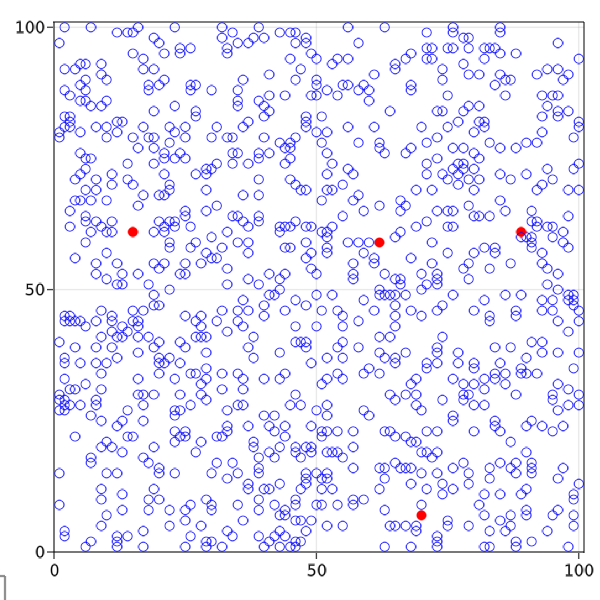

In [13]:
#Initialize Model
model=initialize(; Nstarts = 4,
        periodic = true,
        numagents = 1000,
        griddims = (100,100), 
        p_polym = 1.0,
        p_hyd = 0.024,
        p_GTP_exchange = 0.01,
        p_depolym_GTP = 0.0,
        p_depolym_GDP = 0.2)

# aesthetics
groupcolor(a) = a.polym == 0 ? :blue : a.id <= model.Nstarts ? :red : :green 
groupmarker(a) = a.GDP == true ? '●' : '○'
# figure
fig,stepper = abm_plot(model, ac=groupcolor, am=groupmarker)

fig

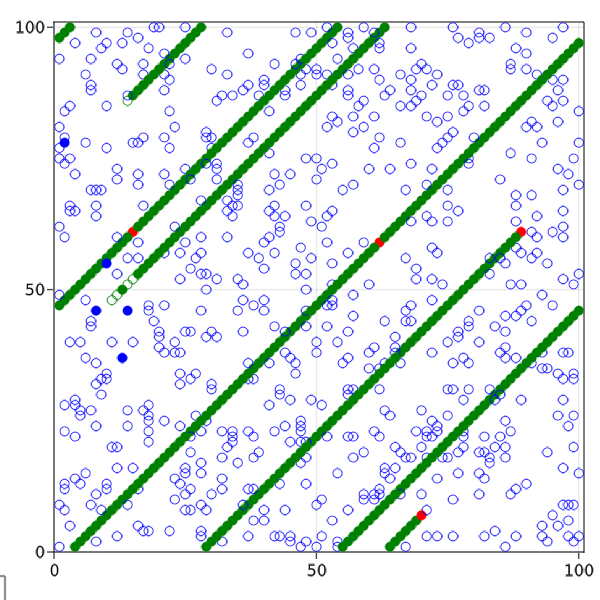

In [14]:
#let the model run to progress the ABM plot and display fig:
Agents.step!(stepper, model, agent_step!, model_step!, 10000)
fig

### 4.1.2 Interactive visualisation with abm_play()
- Initialize model
- abm_play(model, agent_step! [, model_step!]; kwargs...) → fig, abmstepper
- The application has three buttons:

"step": advances the simulation once for spu steps

"run": starts/stops the continuous evolution of the model

"reset": resets the model to its original configuration

In [15]:
#Initialize Model
model=initialize(; Nstarts = 5,
        periodic = true,
        numagents = 1000,
        griddims = (100,100), 
        p_polym = 1.0,
        p_hyd = 0.02,
        p_GTP_exchange = 0.015,
        p_depolym_GTP = 0.0,
        p_depolym_GDP = 0.3) 
# aesthetics
groupcolor(a) = a.polym == 0 ? :blue : a.id <= model.Nstarts ? :red : :green 
groupmarker(a) = a.GDP == true ? '●' : '○'
# figure
fig2, stepper = abm_play(model, agent_step!, model_step!, ac=groupcolor, am=groupmarker)
display(fig2)


GLMakie.Screen(...)

## 4.2 Data collection
To do this, specify which data should be collected, by providing one standard Julia Vector of data-to-collect for agents, for example ```[:id, :pos]```, and another one for the model. The agent data names are given as the keyword ```adata``` and the model as keyword ```mdata``` to the function ```run!```. This function outputs collected data in the form of a DataFrame.

You should save your data immediately after collecting using the Serialize package

In [16]:
#example, which data could be collected from the MT model:
adata = [:pos, :polym, :GDP]
alabels = ["position", "MT_id", "hydrolization"]

function mean_MT_size(model)
    meanMTL = mean([count(i->(i==n), [model.agents[i].polym for i in 1:length(model.agents)]) for n in 1:model.Nstarts])
end

mdata = [mean_MT_size]
mlabels = ["mean MT length"]

1-element Vector{String}:
 "mean MT length"

In [ ]:
#example how to save your data after an experiment:
data_ens = ensemblerun!(models, agent_step!, model_step!, 100000; mdata)
serialize("data/ensemblerun_xyz.jls", data_ens[2])

### 4.2.1 Running model with fixed parameters and collecting data
Running the model and collecting data while the model runs is done with the run! function. 
- run!(model, agent_step! [, model_step!], n::Integer; kwargs...) → agent_df, model_df
- run!(model, agent_step!, model_step!, n::Function; kwargs...) → agent_df, model_df

In [18]:
#example
model=initialize(; Nstarts = 5,
        periodic = true,
        numagents = 1000,
        griddims = (100,100), 
        p_polym = 0.5,
        p_hyd = 0.01,
        p_GTP_exchange = 0.005,
        p_depolym_GTP = 0.0,
        p_depolym_GDP = 0.25)

mdata = [mean_MT_size]

#running the model and data collection
_ , modeldata = run!(model,agent_step!,model_step!, 5000; mdata)
serialize("data/datacollection_xyz.jls", modeldata)

### 4.2.2 Parameterscan
Besides run!, there is also the paramscan function that performs data collection, while scanning ranges of the parameters of the model.
- paramscan(parameters, initialize; kwargs...) → returns adf, mdf
- parameters is a dictionary with key type Symbol which contains various parameters that will be scanned over (as well as other parameters that remain constant)
- The second argument initialize is a function that creates an ABM and returns it
- agent_step!, model_step!, n are also keywords here, that are given to run! as arguments

In [20]:
#example
parameters=Dict(
            :griddims => (100,100),
            :periodic => true,
            :Nstarts => 1,
            :numagents => 1000, 
            :p_hyd => 0.02,                   
            :p_polym=> 1.0 ,    
            :p_depolym_GTP => 0.0,
            :p_depolym_GDP => collect([0.0:0.2:1.0]...),
            :p_GTP_exchange => 0.01) 

mdata = [mean_MT_size]

# Run Model 
_ , paramdata = paramscan(parameters, initialize; mdata, agent_step!, model_step!, n=10000)
serialize("data/paramscan_xyz.jls", paramdata)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


### 4.2.3 Ensemble Run
- ensemblerun!(models::Vector, agent_step!, model_step!, n; kwargs...)
- Perform an ensemble simulation of run! for all model ∈ models
- The function returns agent_df, model_df, models.

In [21]:
#example
models = [initialize(;
            Nstarts = 5,
            periodic = true,
            numagents = 1000,
            griddims = (100,100), 
            p_polym = 1.0,
            p_hyd = x,
            p_GTP_exchange = 0.01,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = 0.5)  
        for x in repeat(collect([0.003:0.006:0.03]...), 5)]

mdata = [mean_MT_size, (:p_hyd)]

data_ens = ensemblerun!(models, agent_step!, model_step!, 1000; mdata)
serialize("data/ensemblerun_xyz.jls", data_ens[2])

### 4.2.4 Interactive - abm_data_exploration()
- Initialize model
- save variable parameters in a dictionary (symbol => abstract vector)
- use abm_data_exploration(model::ABM, agent_step!, model_step!, params=Dict(); kwargs...) returns fig, agent_df, model_df (so you can access collected data after exploration)
- adata, mdata: Same as the keyword arguments of Agents.run!, and decide which data of the model/agents will be collected and plotted below the interactive plot. Notice that data collection can only occur on plotted steps (and thus steps not plotted due to "spu" are also not data-collected).
- alabels, mlabels: If data are collected from agents or the model with adata, mdata, the corresponding plots have a y-label named after the collected data. Instead, you can give alabels, mlabels (vectors of strings with exactly same length as adata, mdata), and these labels will be used instead.

In [5]:
#Initialize Model
model=initialize(; Nstarts = 3,
        periodic = true,
        numagents = 1000,
        griddims = (100,100), 
        p_polym = 1.0,
        p_hyd = 0.02,
        p_GTP_exchange = 0.015,
        p_depolym_GTP = 0.0,
        p_depolym_GDP = 0.3) 

#define variable parameters
params = Dict(
    :numagents => 0:50:5000,
    :p_hyd => 0:0.01:1,
    :p_depolym_GDP => 0:0.01:1,
    :p_GTP_exchange => 0:0.01:1)
# aesthetics
groupcolor(a) = a.polym == 0 ? :blue : a.id <= model.Nstarts ? :red : :green 
groupmarker(a) = a.GDP == true ? '●' : '○'
# data that will be collected during exploration and plotted in the interactive plot
mdata = [mean_MT_size, sd_MT_size]
mlabels =["mean MT length", "sd MT length"]

fig3, adf, mdf = abm_data_exploration(
    model, agent_step!, model_step!, params;
    ac = groupcolor, am = groupmarker, mdata, mlabels)

display(fig3)

GLMakie.Screen(...)

## 4.3 Example of collected data
Here is an example of how collected data looked like:

In [3]:
data = deserialize("paramscan_p_depolym_GDP_10ensemble.jls")


,step,mean_MT_size,p_depolym_GDP,ensemble
,Int64,Float64,Float64,Int64
1,0,1.0,0.0,1
2,1,1.0,0.0,1
3,2,1.0,0.0,1
4,3,1.0,0.0,1
5,4,1.2,0.0,1
6,5,1.2,0.0,1
7,6,1.2,0.0,1
8,7,1.2,0.0,1
9,8,1.4,0.0,1


In [13]:
#if you look closely at the data for p_depolym_GDP = 0.0, you see that in ensemble 4, the meant MT length did not reach its maximum (this ensemble should therefore be excluded)
@subset(data, :p_depolym_GDP .== 0.0, :step .== 9000)

,step,mean_MT_size,p_depolym_GDP,ensemble
,Int64,Float64,Float64,Int64
1,9000,100.0,0.0,1
2,9000,100.0,0.0,12
3,9000,100.0,0.0,23
4,9000,80.0,0.0,34
5,9000,100.0,0.0,45
6,9000,100.0,0.0,56
7,9000,100.0,0.0,67
8,9000,100.0,0.0,78
9,9000,100.0,0.0,89


In [14]:
#grouping by variable parameter and by step so it can be plotted as mean MT size for each parameter and step:
gdf = groupby(@subset(data, :ensemble .!= 34), [:p_depolym_GDP, :step])
summary_df = combine(gdf, [:mean_MT_size] .=> [mean std])

,p_depolym_GDP,step,mean_MT_size_mean,mean_MT_size_std
,Float64,Int64,Float64,Float64
1,0.0,0,1.0,0.0
2,0.0,1,1.08889,0.145297
3,0.0,2,1.22222,0.272845
4,0.0,3,1.35556,0.397213
5,0.0,4,1.46667,0.4
6,0.0,5,1.55556,0.421637
7,0.0,6,1.62222,0.473756
8,0.0,7,1.71111,0.425572
9,0.0,8,1.77778,0.417665


In [19]:
#MT Length over time
f1 = Figure(resolution =(1200, 600))
ax1 = Axis(f1[1,1]; xlabel = "Timesteps", ylabel = "mean MT size", yticks = LinearTicks(5), title = "MT length over time (10x ensemble)")
range = collect(0.0:0.1:1.0)
plot_range = 1:10:10001 #since we are plotting a lot of data points, the lines look thicker than they actually should be, only plotting every 10 steps makes the lines appear thinner in the plot
for (i,v) in enumerate(range)
    sub_data = @subset(summary_df, :p_depolym_GDP .== v)
    band!(sub_data.step, sub_data.mean_MT_size_mean - sub_data.mean_MT_size_std, sub_data.mean_MT_size_mean + sub_data.mean_MT_size_std, color = (co.tab20[i], 0.5))
    lines!(ax1, sub_data.step[plot_range], sub_data.mean_MT_size_mean[plot_range], label = "$v", color = co.tab20[i], linewidth = 3)
end
Legend(f1[2,1], ax1, "p_depolym_GDP", orientation = :horizontal, tellwidth = false, tellheight = true)

f1

## 5. Performance

Please note that an ensemblerun with several ensembles can take quite some computing time. To save time, you can take advantage of parallelization which is integrated into Agents.jl. This is done by providing a ```parallel = true``` keyword argument to ```ensemblerun!``` or ```paramscan```. This uses distributed computing via Julia's ```Distributed``` module. For that, add processes from within a Julia session using: 
```julia 
using Distributed
addprocs(4)
```

For distributed computing to work, all definitions (including packages and functions) must be preceded with @everywhere.
To avoid having @everywhere in everywhere, you can use the ```@everywhere begin...end``` block:

In [ ]:
using Distributed
addprocs(4)

@everywhere begin
    # load Packages:
    using Agents
    using Statistics
    using DataFrames
    using Distributions
    using StatsBase
    using DrWatson: @dict
    using Serialization
    using InteractiveDynamics
    using GLMakie
    import ColorSchemes as co
    using DataFramesMeta

    # load Functions:
    include("01_Agent.jl")
    include("02_Initialization.jl")
    include("03_AgentStep.jl")
    include("04_ModelStep.jl")
    include("05_Analysis.jl")
end    

In [ ]:
@everywhere begin
    models = [initialize(;
            Nstarts = 5,
            periodic = true,
            numagents = 1000,
            griddims = (100,100), 
            p_polym = 1.0,
            p_hyd = x,
            p_GTP_exchange = 0.01,
            p_depolym_GTP = 0.0,
            p_depolym_GDP = 0.5)  
        for x in repeat(collect([0.003:0.003:0.03]...), 10)]
    mdata = [mean_MT_size, (:p_hyd)]
    end
    
data_ens = ensemblerun!(models, agent_step!, model_step!, 10000; mdata, parallel = true);